---
## Pipeline para dados heterogêneos: texto e categorias
---

**Machine Learning em Projetos (Erick Muzart e Fernando Melo)**
###TÓPICOS:

- Balanceamento de classes
- Pipeline
- ColumnTransformer
- GridSearch
- Cross validation
- Xgboost
- Salvar o melhor modelo

Mencionamos pipelines para texto e para dados numéricos e categóricos.
Mas sem demonstração de um pipeline com dados mixtos de múltiplos tipos.

O objeto sklearn que permite um pré-processamento diferenciado por coluna é o `ColumnTransformer`: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

Segue então um exemplo, com os dados das lojas americanas.
https://github.com/b2wdigital/b2w-reviews01

| #   | Field                 | Data type | Description                                                            |
| --- | --------------------- | :-------- | :--------------------------------------------------------------------- |
| 1   | submission_date       | date/time | review submission date (format YYYY-MM-DD hh:mm:ss)                    |
| 2   | reviewer_id           | string    | unique reviewer id                                                     |
| 3   | product_id            | integer   | unique product id                                                      |
| 4   | product_name          | string    | product name                                                           |
| 5   | product_brand         | string    | product brand                                                          |
| 6   | site_category_lv1     | string    | product category - first level                                         |
| 7   | site_category_lv2     | string    | product category - second level                                        |
| 8   | overall_rating        | integer   | overall customer rating, from 1 to 5                                   |
| 9   | recommend_to_a_friend | string    | answer to “would you recommend this product to a friend?” (“Yes”/“No”) |
| 10  | review_title          | text      | review title, introduces or summarizes the review content              |
| 11  | review_text           | text      | main text content of the review                                        |
| 12  | reviewer_birth_year   | integer   | reviewer’s birth year                                                  |
| 13  | reviewer_gender       | string    | reviewer’s gender (”F” for female; ”M” for male)                       |
| 14  | reviewer_state        | string    | reviewer’s Brazilian State, according to the delivery address          |

Código adaptado de: https://stackoverflow.com/questions/57867974/one-pipeline-to-fit-both-text-and-categorical-features


In [56]:
# pip install xgboost
# pip install xgboost

# # CPU only
# conda install -c conda-forge py-xgboost-cpu
# # Use NVIDIA GPU
# conda install -c conda-forge py-xgboost-gpu

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [58]:
# Download do arquivo de dados das Lojas Americanas no GitHub
#url = "https://github.com/b2wdigital/b2w-reviews01/raw/master/B2W-Reviews01.csv"
url = "https://raw.githubusercontent.com/b2wdigital/b2w-reviews01/main/B2W-Reviews01.csv"
df = pd.read_csv(url, sep=',', low_memory=False )

In [59]:
df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG


In [60]:
# Vamos focar em um mix de typos de dados:
# Texto: review_text
# numérico: reviewer_birth_year
# categórico: reviewer_state

# Mais a variável dependente (target): overall_rating (1 a 5)
sub = df[['review_text', 'reviewer_birth_year', 'reviewer_state', 'overall_rating']]

In [61]:
sub.shape

(132373, 4)

In [62]:
# Muitos dados, descartamos as linhas com nulos (NaN)
sub = sub.dropna()

In [63]:
sub.shape

(123321, 4)

In [64]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123321 entries, 0 to 132372
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   review_text          123321 non-null  object 
 1   reviewer_birth_year  123321 non-null  float64
 2   reviewer_state       123321 non-null  object 
 3   overall_rating       123321 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.7+ MB


In [65]:
# Converte para inteiro
sub.reviewer_birth_year = sub.reviewer_birth_year.map(int)

In [66]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123321 entries, 0 to 132372
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   review_text          123321 non-null  object
 1   reviewer_birth_year  123321 non-null  int64 
 2   reviewer_state       123321 non-null  object
 3   overall_rating       123321 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [67]:
import numpy as np

In [68]:
# Discretização simples: negativo com nota de 1 a 3, positivo de 4 a 5
sub['label'] = np.where(sub.overall_rating <= 3, 0, 1)

In [69]:
sub.drop(['overall_rating'], axis=1, inplace=True)

In [70]:
sub

,review_text,reviewer_birth_year,reviewer_state,label
0,Estou contente com a compra entrega rápida o ú...,1958,RJ,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,SC,1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,SP,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,SP,1
4,"A entrega foi no prazo, as americanas estão de...",1994,MG,1
...,...,...,...,...
132368,"Vale muito, estou usando no controle do Xbox e...",1988,RS,1
132369,"Prático e barato, super indico o produto para ...",1979,SP,1
132370,Chegou antes do prazo previsto e corresponde a...,1979,PR,1
132371,"Material fraco, poderia ser melhor. Ficou deve...",1991,RJ,0


In [71]:
print(sub.shape)
sub.label.value_counts()

(123321, 4)


1    75615
0    47706
Name: label, dtype: int64

In [72]:
# # BALANCEAMENTO DAS CLASSES
# # Conta as ocorrências das classes
# count_class_1, count_class_0 = sub.label.value_counts()

# # Separa as classes em dataframes diferentes
# df_class_0 = sub[sub['label'] == 0]
# df_class_1 = sub[sub['label'] == 1]

# # Aleatório under-sampling da classe 1 (classe majoritária)
# df_class_1_under = df_class_1.sample(count_class_0 + 20000)
# df_sub = pd.concat([df_class_1_under, df_class_0], axis=0)

# print(df_sub.shape)
# df_sub.head()

In [73]:
# # TESTE COM BALANCEAMENTO
# X = df_sub[['review_text', 'reviewer_birth_year', 'reviewer_state']]
# y = df_sub['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# m = pipe.fit(X_train, y_train)
# m.score(X_test, y_test)

In [74]:
# Construção do pipeline diferenciado por tipo de coluna

# Pacotes sklearn
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV


In [75]:
from sklearn.linear_model import SGDClassifier

In [76]:
# Detalhes ColumnTransformer: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
preprocessor = ColumnTransformer( 
    transformers=[
        ('text', TfidfVectorizer(), 'review_text'), #TfidfVectorizer accepts column name only between quotes
        ('integer', StandardScaler(), ['reviewer_birth_year']),
        ('category', OneHotEncoder(), ['reviewer_state'])   
    ]
)
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000)),
        #('classifier', SGDClassifier())
    ],
)

In [77]:
X = sub[['review_text', 'reviewer_birth_year', 'reviewer_state']]
y = sub['label']

#X = sub[['review_text']]

In [78]:
print(X.shape)
print(y.shape)

(123321, 3)
(123321,)


In [79]:
# Partição treino/teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
#m.verbose = True

In [81]:
# Usando Regressão Logística
m = pipe.fit(X_train, y_train)

In [82]:
# Usando SGDClassifier
m = pipe.fit(X_train, y_train)

In [83]:
# Regressão Logística: Desempenho com texto da resenha, ano de nascimento e estado do autor da resenha
m.score(X_test, y_test)

0.8743969187107237

In [84]:
# SGDClassifier: Desempenho com texto da resenha, ano de nascimento e estado do autor da resenha
m.score(X_test, y_test)

0.8743969187107237

In [85]:
# Desempenho com texto da resenha
m.score(X_test, y_test)

0.8743969187107237

In [86]:
# Representação do pipeline
# from sklearn import set_config
# set_config()
# set_config(display='diagram')
m.named_steps

{'preprocessor': ColumnTransformer(transformers=[('text', TfidfVectorizer(), 'review_text'),
                                 ('integer', StandardScaler(),
                                  ['reviewer_birth_year']),
                                 ('category', OneHotEncoder(),
                                  ['reviewer_state'])]),
 'classifier': LogisticRegression(max_iter=1000)}

In [87]:
# O pipeline definido anteriormente pode também ser utilizado em uma busca por hiper-parâmetros otimizados
param_grid = {
    'classifier__C': [0.1, 1.0, 10],
    'classifier__penalty': ['l1','l2']
}

In [88]:
# GridSearch : pesquisa sistemática de todas as combinações de híper parâmetros. 
# Cuidado com a explosão combinatorial na pesquisa com múltiplos híper parâmetros com vários valores.
grid_search = GridSearchCV(m, param_grid, n_jobs=-1, verbose=1, cv=3)

Solução alternativa a um Grid Search?

https://scikit-learn.org/stable/modules/grid_search.html

Random Search: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Bayesian Search: https://towardsdatascience.com/hyperparameter-optimization-with-scikit-learn-scikit-opt-and-keras-f13367f3e796?gi=9e463b63d166


In [89]:
grid_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, se

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(),
                                                                         'review_text'),
                                                                        ('integer',
                                                                         StandardScaler(),
                                                                         ['reviewer_birth_year']),
                                                                        ('category',
                                                                         OneHotEncoder(),
                                                                         ['reviewer_state'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 1.0, 10],
                         'classifier__penalty': ['l1', 'l2']},
             verbose=1)

In [90]:
grid_search.score(X_test, y_test)

0.8743969187107237

In [91]:
best = grid_search.best_estimator_.get_params()
best

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('text', TfidfVectorizer(), 'review_text'),
                                   ('integer', StandardScaler(),
                                    ['reviewer_birth_year']),
                                   ('category', OneHotEncoder(),
                                    ['reviewer_state'])])),
  ('classifier', LogisticRegression(max_iter=1000))],
 'verbose': False,
 'preprocessor': ColumnTransformer(transformers=[('text', TfidfVectorizer(), 'review_text'),
                                 ('integer', StandardScaler(),
                                  ['reviewer_birth_year']),
                                 ('category', OneHotEncoder(),
                                  ['reviewer_state'])]),
 'classifier': LogisticRegression(max_iter=1000),
 'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'drop',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor

In [92]:
for p in sorted(param_grid.keys()):
    print(f"{p}: {best[p]}")

classifier__C: 1.0
classifier__penalty: l2


In [93]:
# Para combinações de diferentes métricas de desempenho (avaliação) do seu modelo, veja fonte: https://scikit-learn.org/stable/modules/model_evaluation.html

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

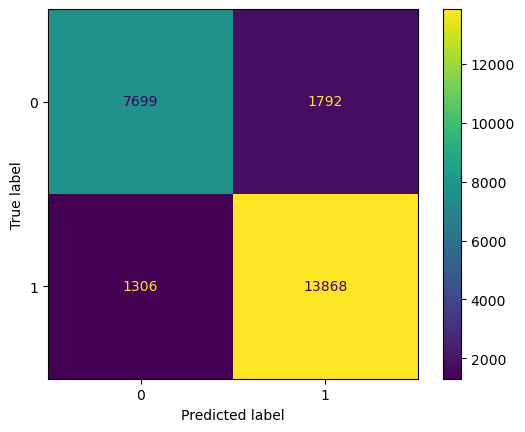

In [95]:
ConfusionMatrixDisplay.from_estimator(grid_search, X_test, y_test.values.ravel(),values_format='d');

In [96]:
import joblib
from joblib import dump, load

In [97]:
best_model = joblib.dump(grid_search,'best_model.pkl')

In [98]:
best_model = joblib.load('best_model.pkl')

In [99]:
preds = best_model.predict(X_test)

In [100]:
preds

array([0, 1, 1, ..., 1, 1, 0])

In [101]:
# Melhor resultado após GridSearchCV em modelo de regressão logística
best_model.best_score_

0.8706920881575737

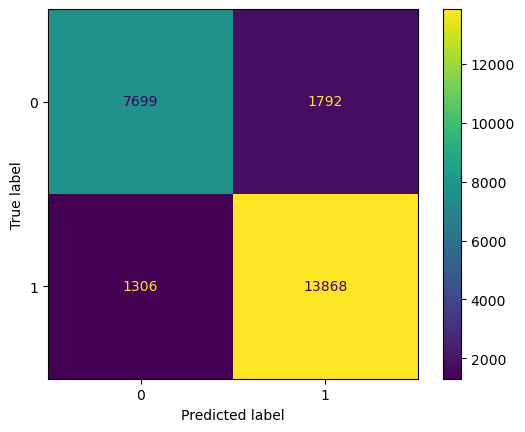

In [102]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test.values.ravel(),values_format='d');

### Teste de xgboost (XGBClassifier)


In [107]:
# !pip install xgboost virtualenv

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 3.3/3.3 MB 7.4 MB/s eta 0:00:00
     ------------------------------------- 468.5/468.5 kB 14.8 MB/s eta 0:00:00
  Using cached platformdirs-3.5.1-py3-none-any.whl (15 kB)


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [108]:
from xgboost import XGBClassifier
# altera o pipeline
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(n_estimators=150,max_depth=4)),
    ],
)

# model_xgboost = XGBClassifier()
model_xgboost= pipe.fit(X_train, y_train)
model_xgboost.score(X_test, y_test)

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
# xgboost_preds = model_xgboost.predict(X_test)
ConfusionMatrixDisplay.from_estimator(model_xgboost, X_test, y_test.values.ravel(),values_format='d');